In [ ]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
df = df [["Make",
        "Model",
        "Year",
        "Engine HP",
        "Engine Cylinders",
        "Transmission Type",
        "Vehicle Style",
        "highway MPG",
        "city mpg",
        "MSRP"]]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
avg_price = df['msrp'].mean()
df['above_average'] = (df.msrp >= avg_price).astype(int)
del df['msrp']
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [5]:
# Making full_train and test set
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Next making train and validation set from full_train set
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Print the proportions of the 3 datasets to the original df
print(f"Proportion of train set: {len(df_train)/len(df)}")
print(f"Proportion of validation set: {len(df_val)/len(df)}")
print(f"Proportion of test set: {len(df_test)/len(df)}")

Proportion of train set: 0.5999664260533826
Proportion of validation set: 0.2000167869733087
Proportion of test set: 0.2000167869733087


In [5]:
variables = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

auc_scores = {}
for var in variables:
    auc = roc_auc_score(df_train['above_average'], df_train[var])
    auc_scores[var] = auc

for var, auc in auc_scores.items():
    if auc < 0.5:
        print(f'Negating variable: {var}')
        df_train[var] = -df_train[var]
        auc_scores[var] = roc_auc_score(df_train['above_average'], df_train[var])

max_auc_var = max(auc_scores, key=auc_scores.get)
print(f"The variable with the highest AUC is: {max_auc_var}")

Negating variable: highway_mpg
Negating variable: city_mpg
The variable with the highest AUC is: engine_hp


In [5]:
# Dropping indexes of these datasets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Creating Dependent Variables
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# Deleting target column i.e. above_average from training datasets
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

dv = DictVectorizer(sparse=True)                              
train_dict = df_train.to_dict(orient='records') 
X_train = dv.fit_transform(train_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

auc = round(roc_auc_score(y_val, y_pred), 3)
print(auc)

0.98


Thresholds where precision and recall intersect: [0.45 0.46 0.47 0.48 0.49 1.  ]


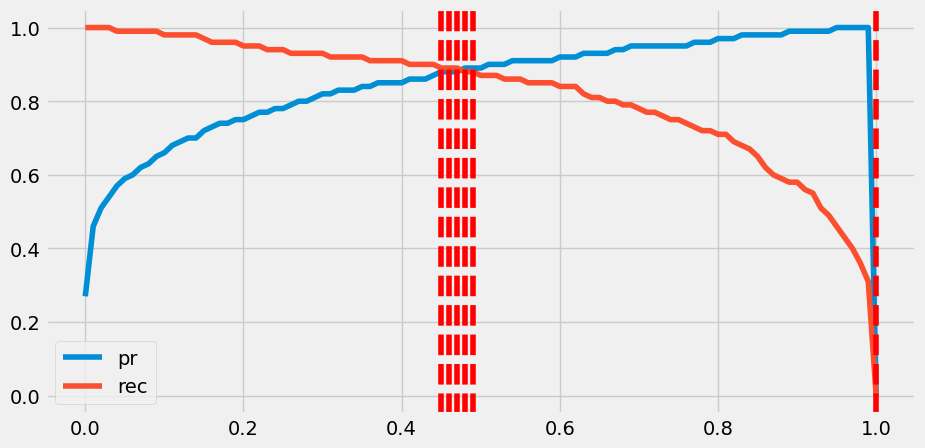

In [6]:
scores = []
thresholds = [round(x, 2) for x in list(np.arange(0, 1, 0.01))]+[1.0]
for t in thresholds:
    probabilities = model.predict_proba(X_val)[:, 1]  # probabilities for the positive class
    predictions = (probabilities >= t).astype(int)  # apply custom threshold
    # Compute confusion matrix values
    tp = ((predictions == 1) & (y_val == 1)).sum()
    fp = ((predictions == 1) & (y_val == 0)).sum()
    fn = ((predictions == 0) & (y_val == 1)).sum()
    # Compute precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    scores.append((t, round(precision, 2), round(recall, 2)))
columns = ['threshold', 'pr', 'rec']
df_scores = pd.DataFrame(scores, columns=columns)
# Set a small tolerance value
tolerance = 0.0101
# Find the thresholds where the absolute difference between precision and recall is less than the tolerance
intersect_thresholds = df_scores[abs(df_scores['pr'] - df_scores['rec']) < tolerance]['threshold']
print(f'Thresholds where precision and recall intersect: {intersect_thresholds.values}')
plt.plot(df_scores.threshold, df_scores['pr'], label='pr')
plt.plot(df_scores.threshold, df_scores['rec'], label='rec')
# Add vertical lines at the thresholds where precision and recall intersect
for threshold in intersect_thresholds:
    plt.axvline(threshold, color='red', linestyle='--')
plt.legend()

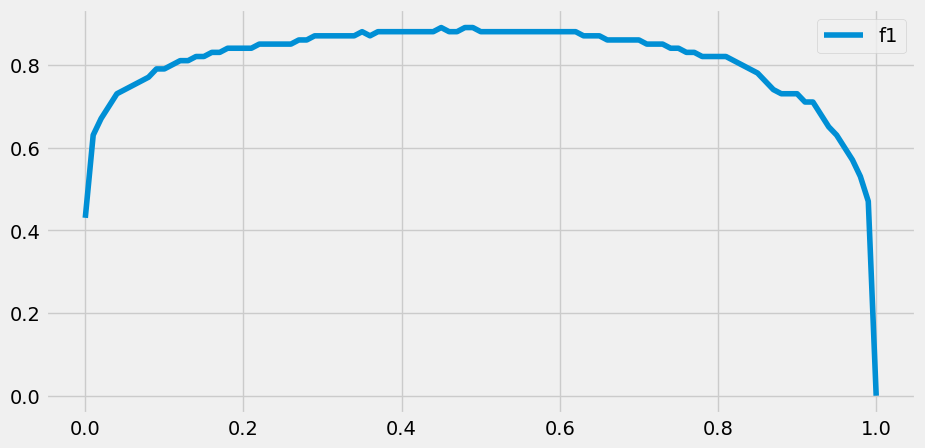

In [8]:
scores = []
thresholds = [round(x, 2) for x in list(np.arange(0, 1, 0.01))]+[1.0]
for t in thresholds:
    probabilities = model.predict_proba(X_val)[:, 1]  # probabilities for the positive class
    predictions = (probabilities >= t).astype(int)  # apply custom threshold
    # Compute confusion matrix values
    tp = ((predictions == 1) & (y_val == 1)).sum()
    fp = ((predictions == 1) & (y_val == 0)).sum()
    fn = ((predictions == 0) & (y_val == 1)).sum()
    # Compute precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2.0 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    scores.append((t, round(f1, 2)))
columns = ['threshold', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()

In [6]:
# Dropping indexes of these datasets
df_full_train = df_full_train.reset_index(drop=True)

# Creating Dependent Variables
y_train = df_full_train.above_average.values

# Deleting target column i.e. above_average from training datasets
del df_full_train['above_average']

dv = DictVectorizer(sparse=True)                              
train_dict = df_full_train.to_dict(orient='records') 
X_train = dv.fit_transform(train_dict)
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc_score = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc_score)

print('AUC scores:', scores)
print('Standard deviation of AUC scores:', np.std(scores))

AUC scores: [0.9784849984874735, 0.9774830122707482, 0.9777173609949249, 0.9772684178238804, 0.9847763347763347]
Standard deviation of AUC scores: 0.0028449761022764355


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
mean_scores = []
std_scores = []
for c in [0.01, 0.1, 0.5, 10]:
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
    
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_fold, y_pred)
        scores.append(auc_score)
    mean_scores.append(round(np.mean(scores), 3))
    std_scores.append(round(np.std(scores), 3))
print(mean_scores)
print(std_scores)

[0.952, 0.962, 0.968, 0.972]
[0.002, 0.01, 0.012, 0.012]
